# Практика №1 Работа с EuroSAT_RGB

In [12]:
#зависимости
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
import numpy as np
import os

## Преварительная обработка данных

### Чтение данных

In [13]:
# Создаю список для хранения данных о файлах и метках
data = []

# Устанавливаю путь к директории с данными EuroSAT
dataset_dir = './EuroSAT_RGB'

# Перечисляю подкаталоги классов
classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

# Прохожу по каждому подкаталогу класса и считываю изображения
for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        image = Image.open(image_path)
        data.append({'image_path': image_path, 'class': class_name})

# Создаю DataFrame из данных
df = pd.DataFrame(data)

# Теперь у меня есть DataFrame с путями к изображениям и соответствующими классами.
 


### Визуализация данных по классам

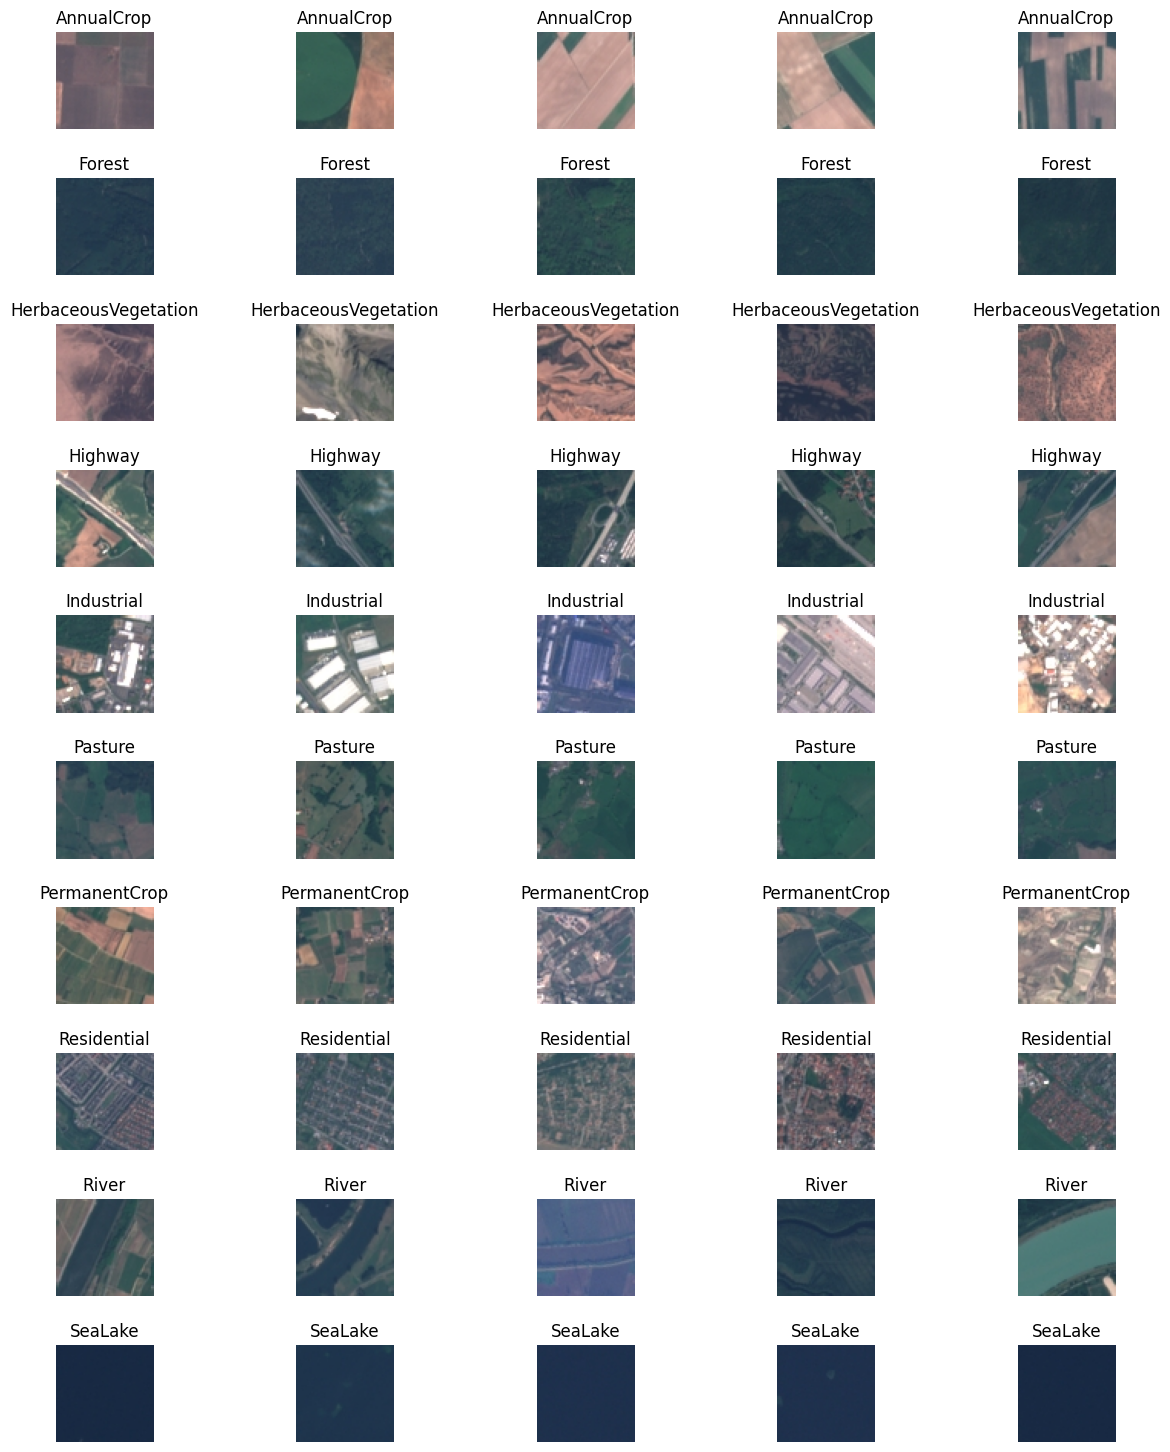

In [6]:
# Получаю уникальные классы из DataFrame
classes = df['class'].unique()

# Создаю подсписок из 5 изображений для каждого класса
subset_images = []

for class_name in classes:
    class_subset = df[df['class'] == class_name].head(5)
    subset_images.append(class_subset)

# Визуализирую по 5 изображений для каждого класса
fig, axes = plt.subplots(10, 5, figsize=(15, 15))

for i, class_name in enumerate(classes):
    for j in range(5):
        if j < len(subset_images[i]):
            image_path = subset_images[i].iloc[j]['image_path']
            image = Image.open(image_path)
            axes[i, j].imshow(image)
            axes[i, j].set_title(class_name)
            axes[i, j].axis('off')

plt.subplots_adjust(top=0.95, bottom=0.01, hspace=0.5, wspace=0.2)
plt.show()

### Исследование датасета

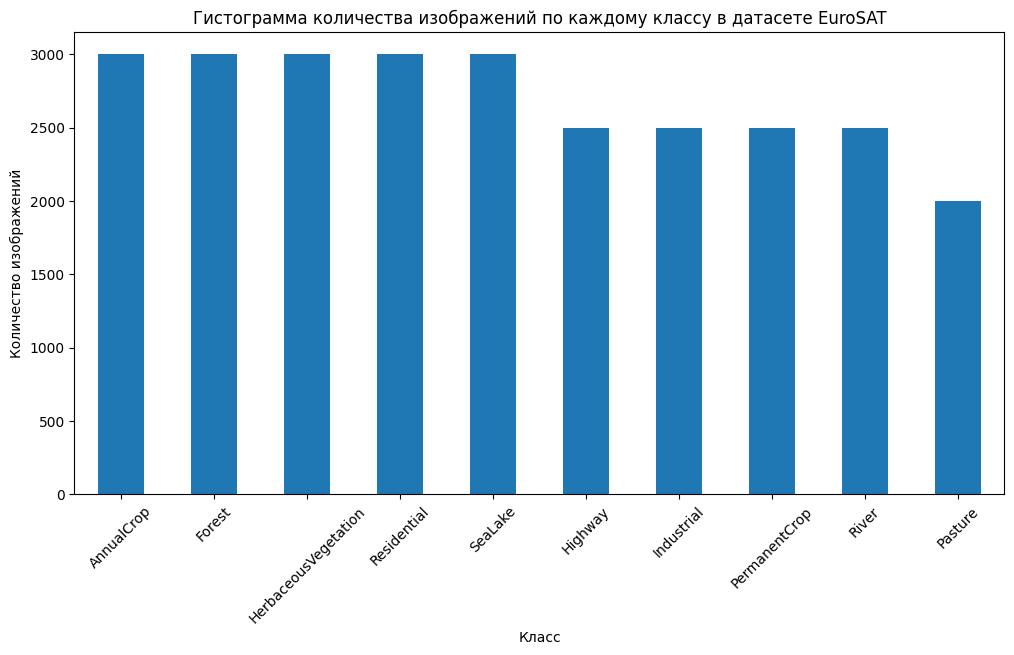

In [16]:
class_counts = df['class'].value_counts()

# Сортирую классы по количеству изображений (необязательно)
class_counts = class_counts.sort_values(ascending=False)

# Построение гистограммы
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar')
plt.title('Гистограмма количества изображений по каждому классу в датасете EuroSAT')
plt.xlabel('Класс')
plt.ylabel('Количество изображений')
plt.xticks(rotation=45)  
plt.show()

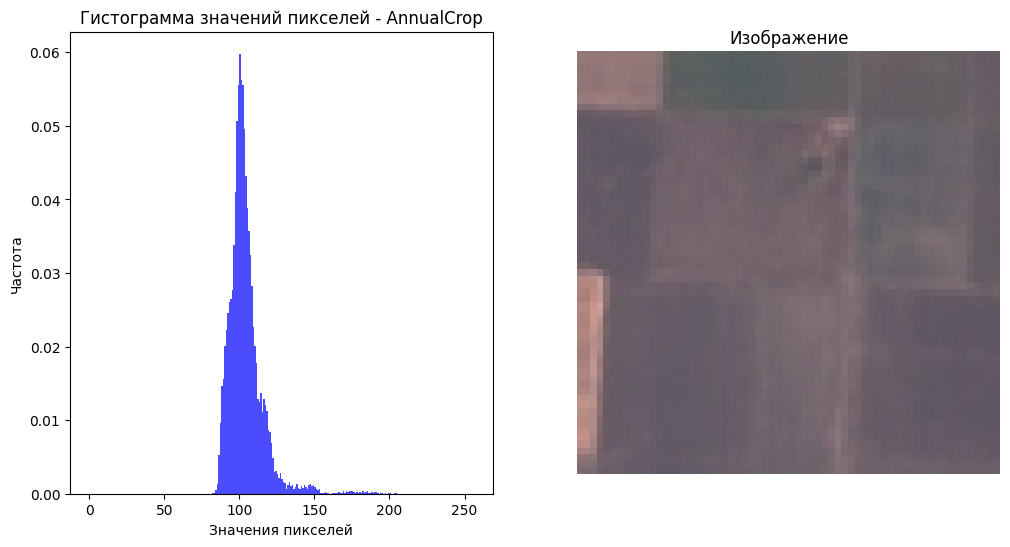

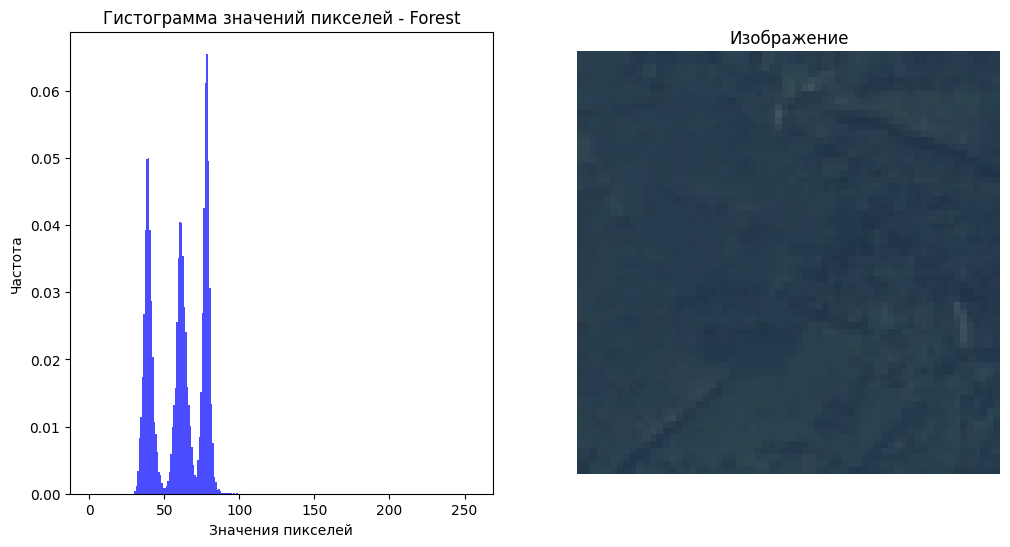

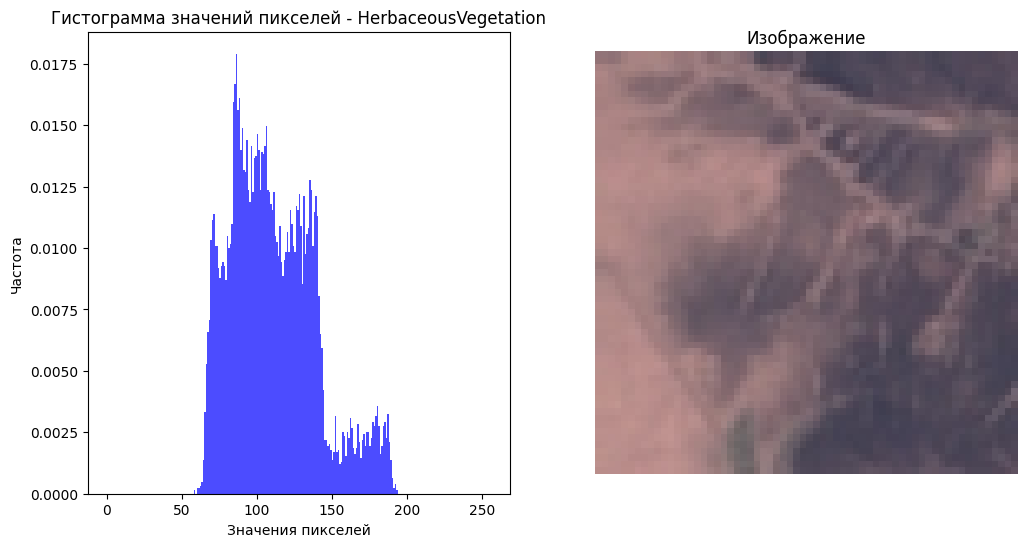

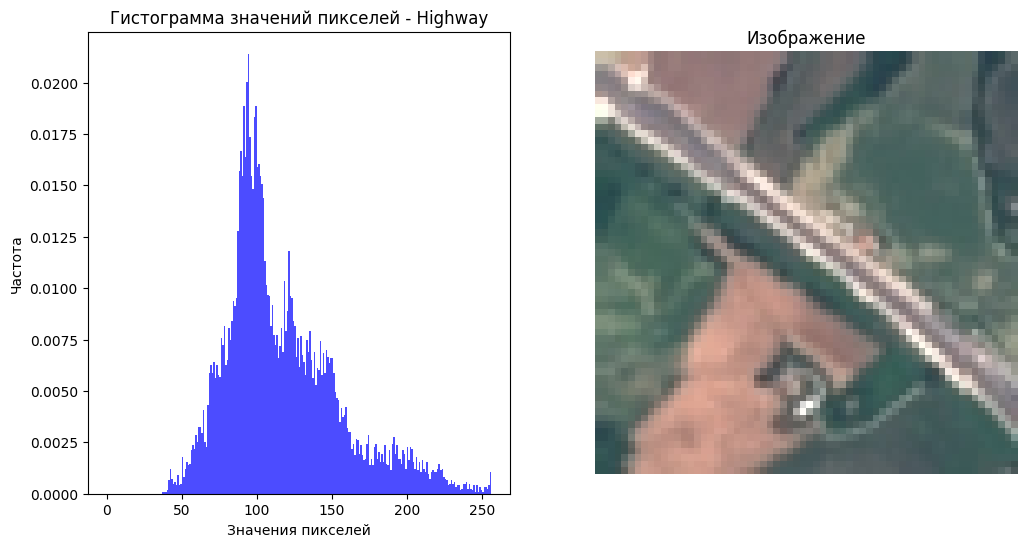

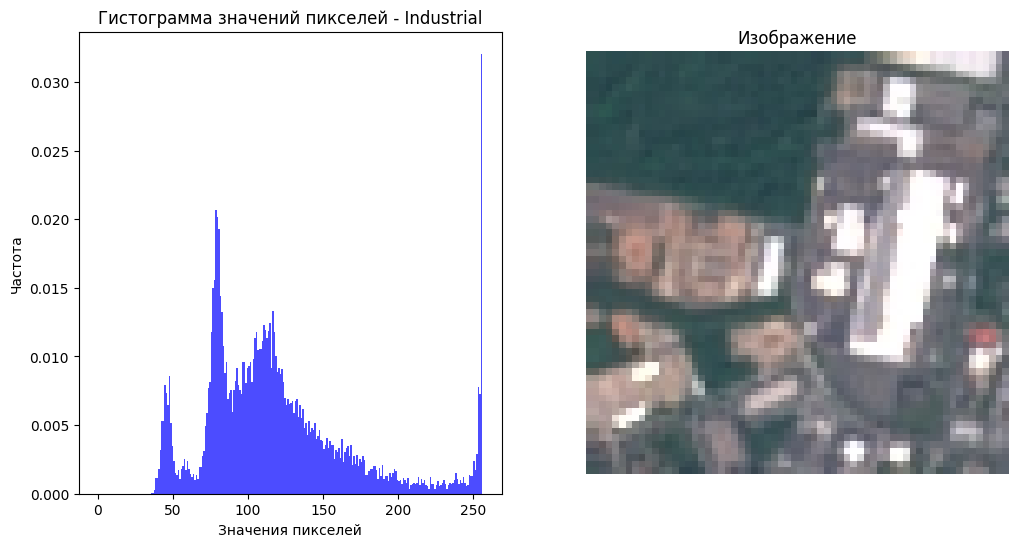

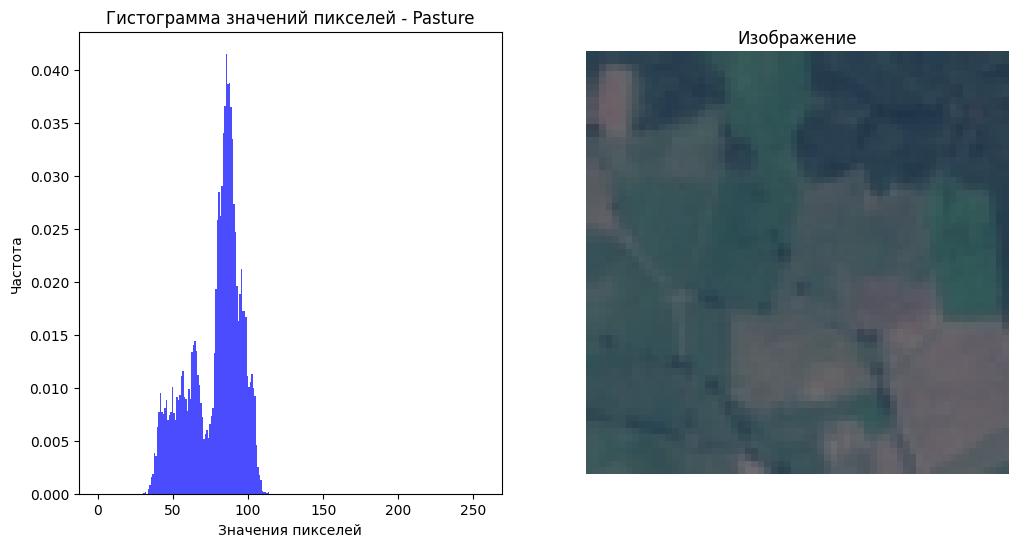

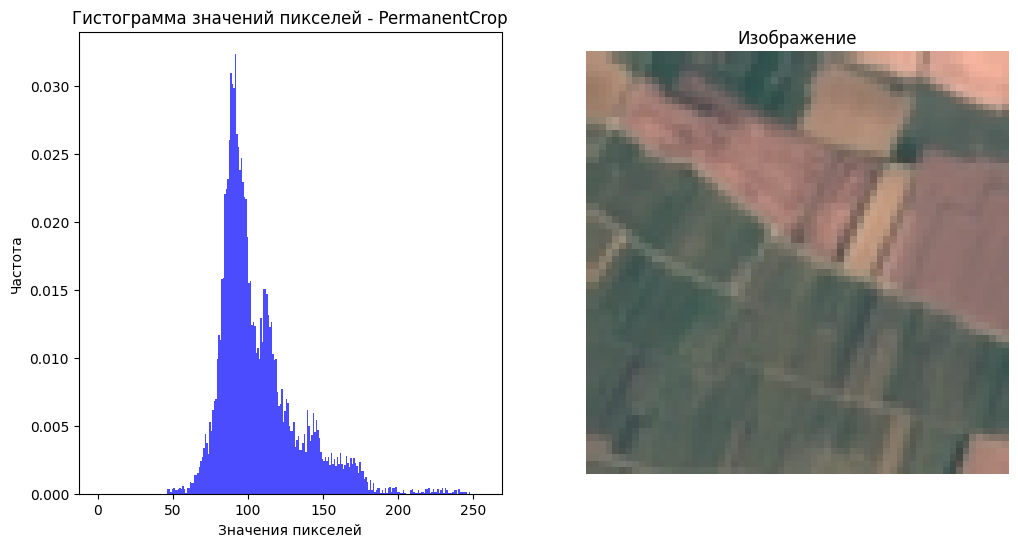

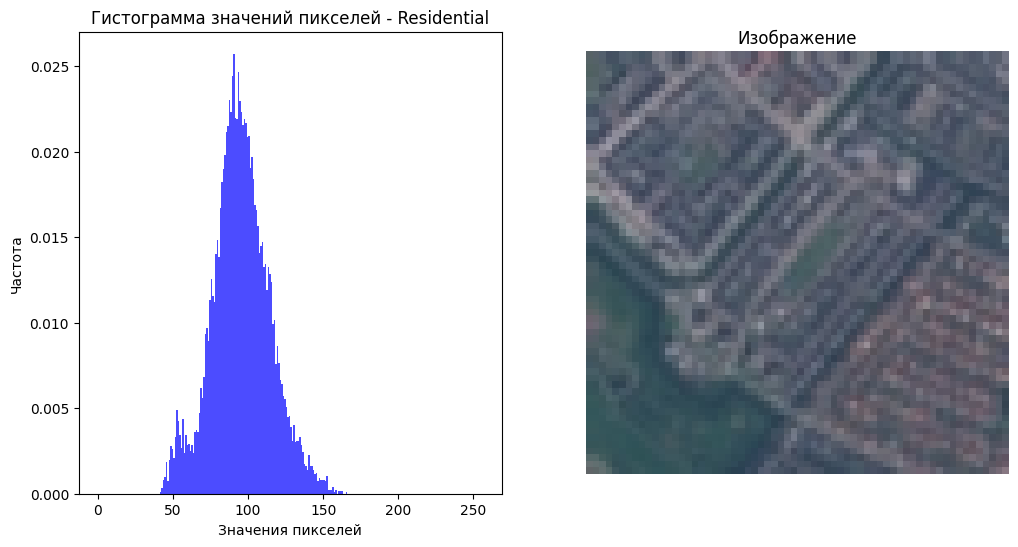

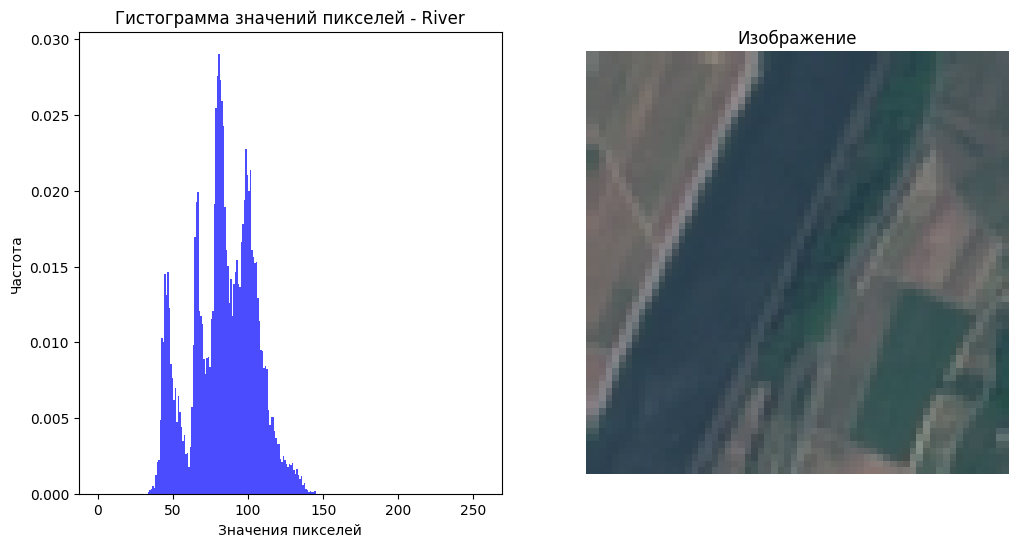

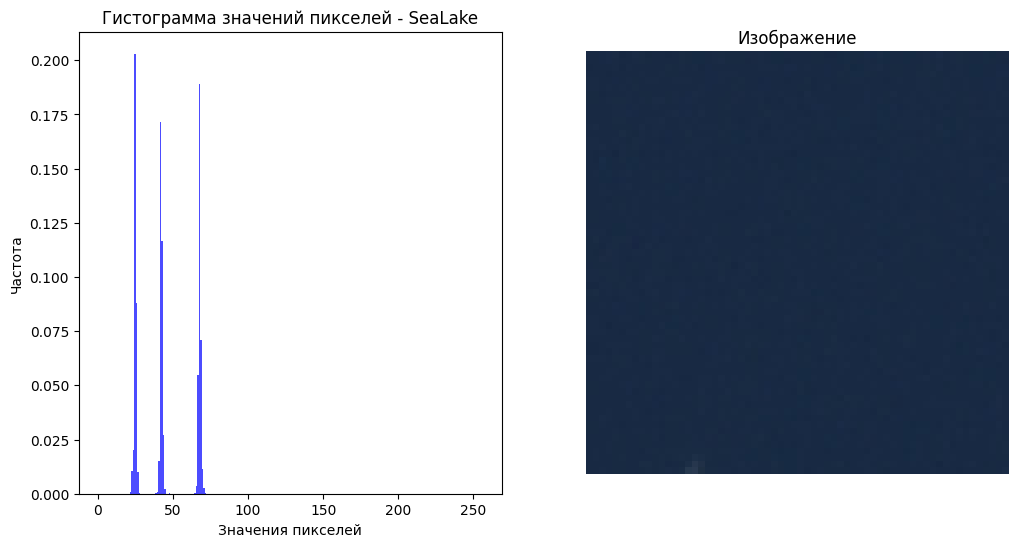

In [15]:
# Функция для создания отчёта (гистограмма и изображение) для одного изображения из каждого класса
def create_report_image(class_name):
    # Отфильтровать DataFrame по заданному классу
    class_df = df[df['class'] == class_name]
    
    # Выбрать первое изображение из класса
    if len(class_df) > 0:
        image_path = class_df.iloc[0]['image_path']
        image = np.array(Image.open(image_path))
        
        # Создать гистограмму значений пикселей для изображения
        plt.figure(figsize=(12, 6))
        
        # Отрисовать гистограмму значений пикселей
        plt.subplot(1, 2, 1)
        plt.hist(image.ravel(), bins=256, range=(0, 256), density=True, color='blue', alpha=0.7)
        plt.title(f'Гистограмма значений пикселей - {class_name}')
        plt.xlabel('Значения пикселей')
        plt.ylabel('Частота')
        
        # Отрисовать само изображение рядом с гистограммой
        plt.subplot(1, 2, 2)
        plt.imshow(image)
        plt.title('Изображение')
        plt.axis('off')
        
        # Сохранить отчёт в файл (опционально)
        # plt.savefig(f'{class_name}_report.png')
        
        plt.show()
    else:
        print(f'В классе {class_name} нет доступных изображений.')

# Пройти по уникальным классам и создать отчёт для каждого класса
for class_name in df['class'].unique():
    create_report_image(class_name)

## Подготовка данных 

In [14]:
import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.optimizers import Adam


In [15]:
# Определение классов
num_classes = 10

# Загрузка и предобработка данных
image_size = (64, 64)  # Размер изображений

# Разделение данных на обучающий и валидационный наборы с сохранением баланса классов
train_df, validation_df = train_test_split(df, test_size=0.2, stratify=df['class'])

# Создание генератора изображений для обучающего набора
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Масштабирование значений пикселей
    rotation_range=20,  # Диапазон поворота изображения
    width_shift_range=0.2,  # Диапазон сдвига по горизонтали
    height_shift_range=0.2,  # Диапазон сдвига по вертикали
    shear_range=0.2,  # Диапазон сдвига/изгиба
    zoom_range=0.2,  # Диапазон масштабирования
    horizontal_flip=True,  # Отражение по горизонтали
    fill_mode='nearest'  # Метод заполнения пикселей при преобразованиях
)



In [16]:
# Создание генератора изображений для валидационного набора
validation_datagen = ImageDataGenerator(rescale=1./255)

# Создание генераторов данных
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='class',
    target_size=image_size,
    batch_size=2048, #АХТУНГ! ТАКОЙ BATCH МОЖЕТ НЕ ПРОГЛОТИТЬ ВАШ КОМПЬЮТЕР (СНАЧАЛА ПОЖАЛУЕТСЯ ВИДЕОКАРТА НА ОБЪЕМ ПАМЯТИ. ПОТОМ НЕРВЫ МОГУТ СДАТЬ У ОПЕРАТИВНОЙ)
    class_mode='categorical',
    color_mode='rgb'
    
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='image_path',
    y_col='class',
    target_size=image_size,
    batch_size=5400,
    class_mode='categorical',
    color_mode='rgb'
)

Found 21600 validated image filenames belonging to 10 classes.
Found 5400 validated image filenames belonging to 10 classes.


In [91]:
batch_x, batch_y = train_generator.next()

# batch_x содержит изображения, а batch_y - соответствующие метки классов
# Проверка формы и типа данных
print("Форма batch_x:", batch_x.shape)
print("Тип данных batch_x:", batch_x.dtype)
print("Форма batch_y:", batch_y.shape)
print("Тип данных batch_y:", batch_y.dtype)

Форма batch_x: (2048, 64, 64, 3)
Тип данных batch_x: float32
Форма batch_y: (2048, 10)
Тип данных batch_y: float32


In [39]:
NUM_EPOCHS = 300 # Количество эпох обучения

DROPOUT_CHANCE = 0.3 # Вероятность того, что одно из значений во входных данных будет "утеряно". Снижает вероятность переобучения

LEARNING_RATE = 0.03 # Темп обучения
GAMMA = 0.9 # Множитель затухания темпа обучения
STEP_SIZE = 5 # Количество эпох между затуханиями

MOMENTUM = 0.5 # Импульс градиентного спуска
WEIGHT_DECAY = 0 # Снижение значений параметров модели


## Создание и Обучение модели


In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [93]:
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True, monitor='val_categorical_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=GAMMA, patience=STEP_SIZE, min_lr=0.00001, verbose=1)

In [8]:
from keras.applications import ResNet50, ResNet50V2, ResNet152V2, VGG16, VGG19 # рубрика э-э-э-эксперименты. на базе готовых предварительно обученнных моделей работаю
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, Input

def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    input_tensor = Input(shape=input_shape)
    
    if (cnn_base == 'ResNet50') or (cnn_base == 'ResNet50V2') or (cnn_base == 'ResNet152V2'):
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)
        elif cnn_base == 'ResNet50V2':
            conv_base = ResNet50V2(include_top=False, weights='imagenet', input_tensor=input_tensor)
        else:
            conv_base = ResNet152V2(include_top=False, weights='imagenet', input_tensor=input_tensor)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
    
    elif (cnn_base == 'VGG16') or (cnn_base == 'VGG19'):
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
        else:
            conv_base = VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
    
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model


In [46]:
resnet50_model = compile_model('ResNet50', (64, 64, 3), 10, Adam(lr=1e-2), fine_tune=None)
resnet50_model.summary()

C:\Users\Evgenie\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

In [54]:
resnet50_history = resnet50_model.fit(train_generator,
                             epochs=NUM_EPOCHS,
                             validation_data=validation_generator,
                             callbacks=[model_checkpoint, early_stopping])

Epoch 1/300
11/11 [==============================] - ETA: 0s - loss: 1.7654 - categorical_accuracy: 0.3449
Epoch 1: val_categorical_accuracy improved from -inf to 0.42370, saving model to best_model.h5
11/11 [==============================] - 14s 1s/step - loss: 1.7654 - categorical_accuracy: 0.3449 - val_loss: 1.6742 - val_categorical_accuracy: 0.4237
Epoch 2/300
11/11 [==============================] - ETA: 0s - loss: 1.7251 - categorical_accuracy: 0.3559
Epoch 2: val_categorical_accuracy improved from 0.42370 to 0.43574, saving model to best_model.h5
11/11 [==============================] - 14s 1s/step - loss: 1.7251 - categorical_accuracy: 0.3559 - val_loss: 1.5863 - val_categorical_accuracy: 0.4357
Epoch 3/300
11/11 [==============================] - ETA: 0s - loss: 1.6862 - categorical_accuracy: 0.3738
Epoch 3: val_categorical_accuracy did not improve from 0.43574
11/11 [==============================] - 14s 1s/step - loss: 1.6862 - categorical_accuracy: 0.3738 - val_loss: 1.5626

## Проверка точности

In [56]:
def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show()

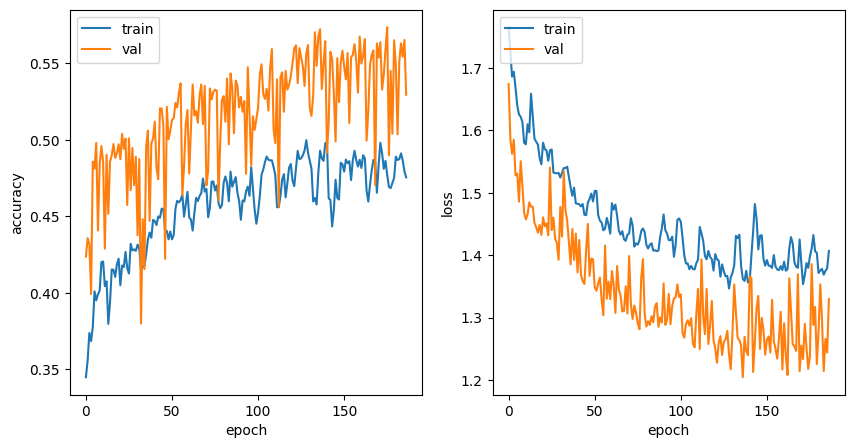

In [57]:
plot_history(resnet50_history)

In [132]:
from keras.models import load_model
best_model = compile_model('ResNet50', (64, 64, 3), 10, Adam(lr=1e-2), fine_tune=None)

# Загрузка сохраненных весов в модель
best_model.load_weights('best_model_resnet.h5')

C:\Users\Evgenie\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [136]:
# пустая матрицу ошибок
confusion_matrix = np.zeros((10, 10), dtype=int)

# Пройдитесь по всем изображениям из validation_generator
for i in range(len(validation_generator)):
    batch_x, batch_y = validation_generator[i]
    predictions = best_model.predict(batch_x)
    
    # истинные классы для этого пакета
    true_classes = np.argmax(batch_y, axis=1)
    
    #  предсказанные классы
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Обновите матрицу ошибок на основе истинных и предсказанных классов
    for j in range(len(true_classes)):
        confusion_matrix[true_classes[j], predicted_classes[j]] += 1

# Выведите матрицу ошибок
print("Confusion Matrix:")
print(confusion_matrix)

#p.s вышло не очень читаемо

169/169 [==============================] - 2s 9ms/step
Confusion Matrix:
[[432   5  22  10   8  20  47   7  38  11]
 [  0 493  36   0   0  28   0   0   4  39]
 [ 51  17 234  14  30  28  92 117  14   3]
 [133   2  28  36  42   8  96  51 102   2]
 [  2   0   0   2 449   0  18  28   1   0]
 [ 74  36  96  12   0  67  14  10  60  31]
 [ 81   2  34  15  37   7 192 104  28   0]
 [  0   0  10   1  38   0  28 523   0   0]
 [139  17  46  42  17  25  41  26 140   7]
 [ 37  59   5   0   0   8   0   0   7 484]]


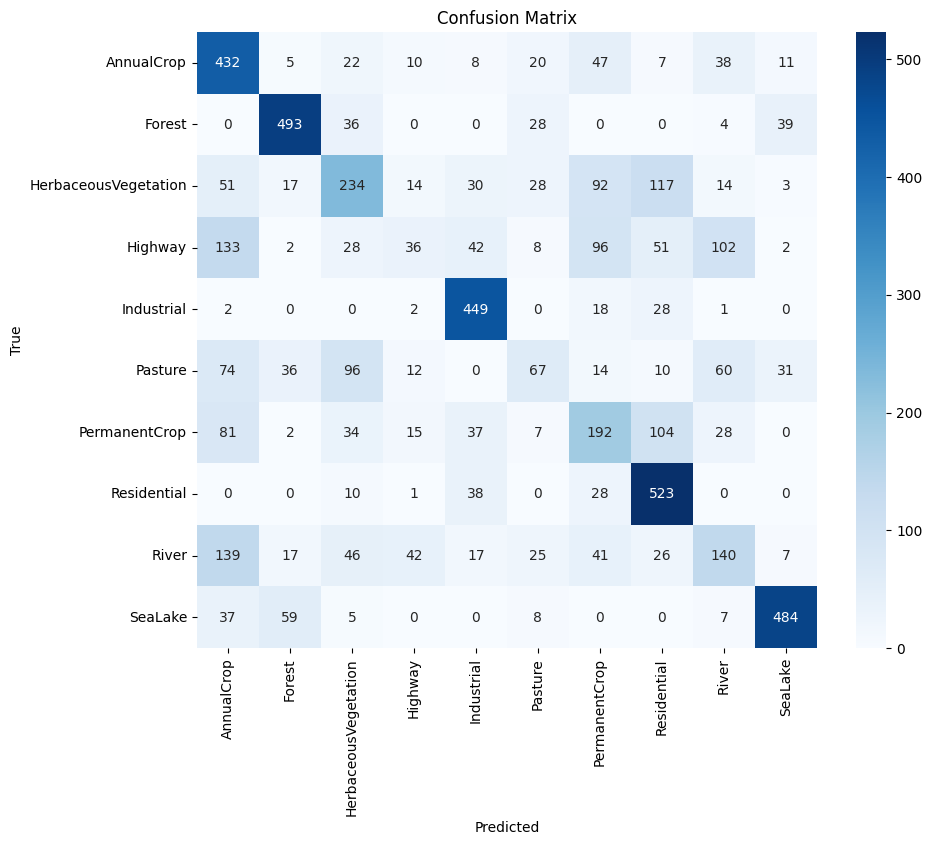

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Создайте матрицу ошибок
confusion = confusion_matrix(true_classes, predicted_classes)

# Визуализируйте матрицу ошибок с использованием seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
#p.s уже лучше. но воображение не поражает результат особенно для highway, pasture

## Обучение версия 2

In [95]:
resnet50V2_model = compile_model('ResNet50V2', (64,64,3), 10, Adam(lr=1e-2), fine_tune=None)
resnet50V2_model.summary()

C:\Users\Evgenie\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


94668760/94668760 [==============================] - 77s 1us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                          

In [96]:
resnet50V2_history = resnet50V2_model.fit(train_generator,
                             epochs=NUM_EPOCHS,
                             validation_data=validation_generator,
                             callbacks=[model_checkpoint, early_stopping])

C:\Users\Evgenie\AppData\Local\Temp\ipykernel_11164\3271798384.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet50V2_history = resnet50V2_model.fit_generator(train_generator,


Epoch 1/300
11/11 [==============================] - ETA: 0s - loss: 18.1106 - categorical_accuracy: 0.4528
Epoch 1: val_categorical_accuracy improved from -inf to 0.64204, saving model to best_model.h5
11/11 [==============================] - 37s 3s/step - loss: 18.1106 - categorical_accuracy: 0.4528 - val_loss: 1.3349 - val_categorical_accuracy: 0.6420
Epoch 2/300
11/11 [==============================] - ETA: 0s - loss: 1.1277 - categorical_accuracy: 0.6555
Epoch 2: val_categorical_accuracy improved from 0.64204 to 0.75741, saving model to best_model.h5
11/11 [==============================] - 14s 1s/step - loss: 1.1277 - categorical_accuracy: 0.6555 - val_loss: 0.7702 - val_categorical_accuracy: 0.7574
Epoch 3/300
11/11 [==============================] - ETA: 0s - loss: 0.8097 - categorical_accuracy: 0.7356
Epoch 3: val_categorical_accuracy improved from 0.75741 to 0.80519, saving model to best_model.h5
11/11 [==============================] - 14s 1s/step - loss: 0.8097 - categorica

## Проверка точности 2

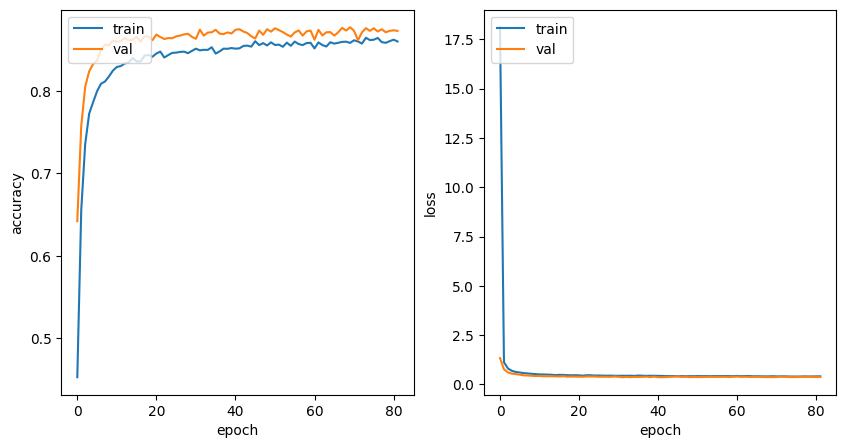

In [97]:
plot_history(resnet50V2_history)

In [9]:
best_model = compile_model('ResNet50V2', (64, 64, 3), 10, Adam(lr=1e-2), fine_tune=None)

# Загрузка сохраненных весов в модель
best_model.load_weights('best_model_resnetV2.h5')

C:\Users\Evgenie\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [131]:
# пустая матрицу ошибок
confusion_matrix = np.zeros((10, 10), dtype=int)

# Пройдитесь по всем изображениям из validation_generator
for i in range(len(validation_generator)):
    batch_x, batch_y = validation_generator[i]
    predictions = best_model.predict(batch_x)
    
    # истинные классы для этого пакета
    true_classes = np.argmax(batch_y, axis=1)
    
    #  предсказанные классы
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Обновите матрицу ошибок на основе истинных и предсказанных классов
    for j in range(len(true_classes)):
        confusion_matrix[true_classes[j], predicted_classes[j]] += 1

# Выведите матрицу ошибок
print("Confusion Matrix:")
print(confusion_matrix)

169/169 [==============================] - 1s 8ms/step
Confusion Matrix:
[[515   3   4   9   0  13  30   0  24   2]
 [  0 576   1   1   0  10   0   3   6   3]
 [  0  10 495  10   3  12  38  25   7   0]
 [ 12   0   7 396   9   2  16   7  51   0]
 [  0   0   1  10 458   0   3  26   2   0]
 [  4  15  12   5   1 335  13   3  12   0]
 [ 16   0  44  27   8   8 371  23   3   0]
 [  0   1   6   0  20   0   1 567   5   0]
 [  6   1   2  35   1   5   0   1 449   0]
 [  2   9   1   1   0   4   0   0  11 572]]


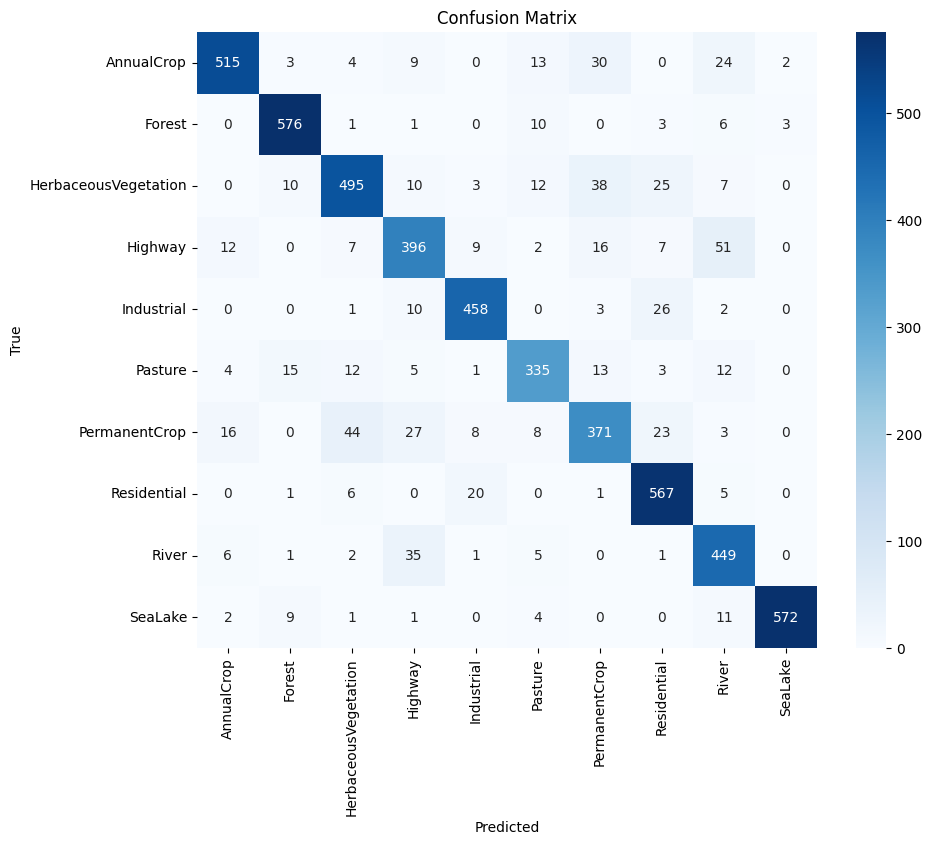

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Создайте матрицу ошибок
confusion = confusion_matrix(true_classes, predicted_classes)

# Визуализируйте матрицу ошибок с использованием seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
#совсем другое дело

## Бонус визуализации  результатов лучшей модели

там 168 изображений (страниц) по 32 предсказания

In [21]:
from ipywidgets import interact

# Функция для отображения страницы с изображениями
def display_images(page_number):
    i = page_number * 32
    if i >= len(batch_x):
        print("Нет больше изображений.")
        return
    
    fig = plt.figure(figsize=(15, 8))
    for j in range(32):
        if i + j >= len(batch_x):
            break
        ax = fig.add_subplot(4, 8, j + 1)
        ax.imshow(batch_x[i + j])
        true_class = class_names[np.argmax(batch_y[i + j])]
        predicted_class = class_names[np.argmax(predictions[i + j])]

        if true_class == predicted_class:
            text_color = 'green'  # Зеленый текст для верных предсказаний
        else:
            text_color = 'red'  # Красный текст для неверных предсказаний

        ax.set_title(f'True: {true_class}\nPredicted: {predicted_class}', linespacing=1.5, color=text_color, size=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Интерактивный виджет для выбора страницы
interact(display_images, page_number=(0, len(batch_x) // 32))


interactive(children=(IntSlider(value=84, description='page_number', max=168), Output()), _dom_classes=('widge…

<function __main__.display_images(page_number)>